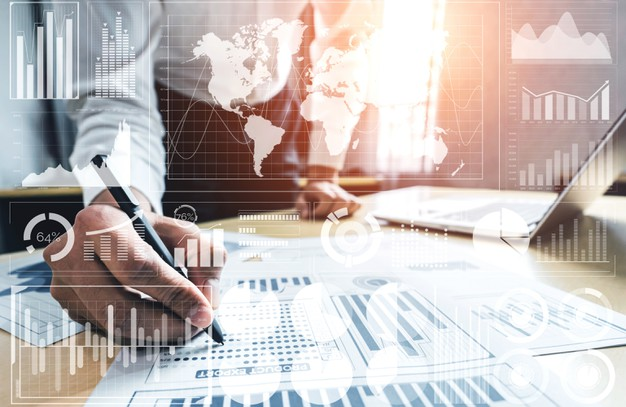

# Notebook of Thomas Truyts - Risk & Fraud Analysis

## 1. Import libraries & Upload files

In [11]:
print ("IMPORTING LIBRARIES...")
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import re
from deap import creator, base, tools, algorithms 
import random
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import time
from imblearn.over_sampling import SMOTENC
from sklearn import tree
from sklearn.preprocessing import PolynomialFeatures
import random
import requests
from requests.auth import HTTPBasicAuth

IMPORTING LIBRARIES...


In [12]:
print ("LOADING DATASETS...")
try: # reading train csv from local file
    df_train = pd.read_csv("mfalonso__6aQ6IxU7Va__train.csv")
    df_train.head()
except: # reading train csv from the internet if it is the first time
    import urllib
    csv_train = urllib.request.urlopen("http://manoelutad.pythonanywhere.com/static/uploads/mfalonso__6aQ6IxU7Va__train.csv")
    csv_train_content = csv_train.read()
    with open("mfalonso__6aQ6IxU7Va__train.csv", 'wb') as f:
            f.write(csv_train_content)
    df_train = pd.read_csv("mfalonso__6aQ6IxU7Va__train.csv")

    
try: # reading test csv from local file
    df_test = pd.read_csv("mfalonso__6aQ6IxU7Va__test.csv")
    df_test.head()
except: # reading test csv from the internet if it is the first time
    import urllib
    csv_test = urllib.request.urlopen("http://manoelutad.pythonanywhere.com/static/uploads/mfalonso__6aQ6IxU7Va__test.csv")
    csv_test_content = csv_test.read()
    with open("mfalonso__6aQ6IxU7Va__test.csv", 'wb') as f:
            f.write(csv_test_content)
    df_test = pd.read_csv("mfalonso__6aQ6IxU7Va__test.csv")

LOADING DATASETS...


## 2. Transformation

### 2.1. Replace NaN's with 0's

In [13]:
print ("STEP 1: DOING MY TRANSFORMATIONS...")
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

STEP 1: DOING MY TRANSFORMATIONS...


### 2.2. Remove & create features (Not used)

In [14]:
def feature_importance(model_or_pipe):
    feat_imp = model_or_pipe.feature_importances_
    features = X_train.columns
    feat_imp_dt = pd.DataFrame({
        "feature": features, 
        "importance": feat_imp
    }).sort_values(by="importance", ascending=False).reset_index(drop=True)

    return feat_imp_dt

In [15]:
model_0 = tree.DecisionTreeClassifier(random_state = 42)
model_0_name = "Decision Tree Classifier"

model_0.fit(X_train, y_train)
feature_importance1 = feature_importance(model_0)
feature_importance1

zeros = feature_importance1.loc[feature_importance1['importance'] == 0]
not_used_feat = list(zeros["feature"])

for c in not_used_feat:
    X_train.drop(columns=c)
    X_test.drop(columns=c)
    
poly = PolynomialFeatures(degree=2, include_bias=False)
new_var = poly.fit_transform(X_train)
new_var1 = poly.fit_transform(X_test)

for i in range(0,3569):
    X_train[f"new_var{i}"] = new_var[:,i]
    X_test[f"new_var{i}"] = new_var1[:,i]

### 2.3. SMOTE

In [16]:
print ("STEP 2: SELECTING CHARACTERISTICS TO ENTER INTO THE MODEL...")
def get_specific_columns(df, data_types, to_ignore = list(), ignore_target = False):
    columns = df.select_dtypes(include=data_types).columns
    if ignore_target:
        columns = filter(lambda x: x not in to_ignore, list(columns))
    return list(columns)

output_var = df_train.columns[-1]
in_model = get_specific_columns(df_train, ["float64", "int64"], [output_var], ignore_target = True)

STEP 2: SELECTING CHARACTERISTICS TO ENTER INTO THE MODEL...


In [17]:
from imblearn.over_sampling import SMOTENC
X_train = df_train[in_model]
y_train = df_train[output_var]
X_test = df_test[in_model]

numbers = list(range(0,61))
smote_cat = SMOTENC(categorical_features = numbers)
X_train_def, y_train_def= smote_cat.fit_resample(X_train, y_train)

## 3. Model

### 3.1. Optimize weights

In [18]:
# Here I randomize the weights for the voting regressor and print their GINI score. Like this I can see 
# which weights give the highest GINI

seed = 100
for i in range(100):
    weight1 = random.randint(1, 10)
    weight2 = random.randint(1, 10)
    weight3 = random.randint(1, 10)
    base_learners = [
                ('RandomForest', RandomForestClassifier(random_state=seed, max_depth = 45, max_features = 0.4, n_estimators = 900)),
                ('Bagging',BaggingClassifier(random_state=seed)),
                ('ExtraTrees', ExtraTreesClassifier(random_state=seed, max_depth = 45, max_features = 0.4, n_estimators = 900)),
                ]   

    clf = VotingClassifier(estimators=base_learners, voting = 'soft', weights = [weight1, weight2, weight3])
    
    fitted_model = clf.fit(X_train_def, y_train_def)
    pred_train = fitted_model.predict_proba(X_train_def)[:,1]
    pred_test  = fitted_model.predict_proba(X_test)[:,1]
    
    gini_score = 2*roc_auc_score(y_train_def, pred_train)-1

    df_test['pred'] = pred_test
    df_test['id'] = df_test.index#df_test.iloc[:,0]
    df_test_tosend = df_test[['id','pred']]

    filename = "df_test_tosend.csv"
    df_test_tosend.to_csv(filename, sep=',')
    url = 'http://manoelutad.pythonanywhere.com/uploadpredictions/6aQ6IxU7Va'
    files = {'file': (filename, open(filename, 'rb')),
         'ipynbcode': ('6aQ6IxU7Va.ipynb', open('6aQ6IxU7Va.ipynb', 'rb'))}


    #rsub = requests.post(url, files=files)
    rsub = requests.post(url, files=files, auth=HTTPBasicAuth("ThomasTruyts", "sha256$KBrB3xwR$4d349a30cd10685904ddbec036a23cc583d34df41d6798460f96684c254fec89"))
    resp_str = str(rsub.text)
    print ("RESULT SUBMISSION: ", resp_str)
    time.sleep(31)
    print(weight1)
    print(weight2)
    print(weight3)

RESULT SUBMISSION:  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>

6
9
8
RESULT SUBMISSION:  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>

2
2
1
RESULT SUBMISSION:  Competition / competición: 6aQ6IxU7Va - gini = 0.4903488017449331
4
10
9


KeyboardInterrupt: 

### 3.2. Prediction & Submission

In [21]:
# I loop through random seeds because changing the seed can increase the GINI coefficient with 1%.

print ("STEP 5: SUBMITTING THE RESULTS... DO NOT CHANGE THIS PART!")
while True:
    seed = np.random.randint(0,10000)
    base_learners = [
                ('RandomForest', RandomForestClassifier(n_estimators=10000, oob_score=True, random_state=seed
                                                        ,max_features='log2', bootstrap = 'True', 
                                                        min_samples_split = 2, min_samples_leaf = 1, 
                                                        criterion = 'entropy', n_jobs=5)),
                ('Bagging', BaggingClassifier(random_state=seed)),
                ('ExtraTrees', ExtraTreesClassifier(random_state=seed)),
                ]   

    clf = VotingClassifier(estimators=base_learners, voting = 'soft', weights = [9,1,6])
    
    fitted_model = clf.fit(X_train_def, y_train_def)
    pred_train = fitted_model.predict_proba(X_train_def)[:,1]
    pred_test  = fitted_model.predict_proba(X_test)[:,1]
    
    gini_score = 2*roc_auc_score(y_train_def, pred_train)-1

    df_test['pred'] = pred_test
    df_test['id'] = df_test.index#df_test.iloc[:,0]
    df_test_tosend = df_test[['id','pred']]

    filename = "df_test_tosend.csv"
    df_test_tosend.to_csv(filename, sep=',')
    url = 'http://manoelutad.pythonanywhere.com/uploadpredictions/6aQ6IxU7Va'
    files = {'file': (filename, open(filename, 'rb')),
         'ipynbcode': ('6aQ6IxU7Va.ipynb', open('6aQ6IxU7Va.ipynb', 'rb'))}


    #rsub = requests.post(url, files=files)
    rsub = requests.post(url, files=files, auth=HTTPBasicAuth("ThomasTruyts", "sha256$KBrB3xwR$4d349a30cd10685904ddbec036a23cc583d34df41d6798460f96684c254fec89"))
    resp_str = str(rsub.text)
    print ("RESULT SUBMISSION: ", resp_str)
    time.sleep(31)    
    print(seed)

STEP 5: SUBMITTING THE RESULTS... DO NOT CHANGE THIS PART!
RESULT SUBMISSION:  Competition / competición: 6aQ6IxU7Va - gini = 0.5333967966432223
5807


KeyboardInterrupt: 